# Section 1: Accessing Files on Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# copy python files into local dir
from shutil import copyfile
base_path = '/content/drive/My Drive/WORK/Laidlaw Summer Research 2019/daytrader/'
files = ['data_loader.py', 'model_file.py', 'utils.py']
for file_name in files:
  copyfile(f'{base_path}{file_name}', f'./{file_name}')

# import files
%tensorflow_version 2.x
from data_loader import *
from model_file import *
from utils import *

# initialize path locations
periods = [4, 5, 6, 8, 12, 14, 20, 50]
prices_path = f'{base_path}huge_stock_csvs/'
indicators_path = get_indicators_path(base_path, periods)
checkpts_path = f'/content/drive/My Drive/WORK/Laidlaw Summer Research 2019/daytrader_checkpts/checkpts/'
models_path = f'/content/drive/My Drive/WORK/Laidlaw Summer Research 2019/daytrader_checkpts/models/'

TensorFlow 2.x selected.


# Section 2: Data Wrangling with Technical Indicators

The full list of indicators available is:

```
['sma', 'ema', 'wma', 'bbands_high', 'bbands_low', 'per_b_high', 'per_b_low', 'trima', 'rsi', 'willr', 'atr', 'trange', 'plus_di', 'minus_di', 'dx', 'adx', 'roc', 'macd',  'macd_histogram', 'cci', 'aroon_osc', 'adl', 'chaikin_osc', 'chaikin_mf', 'obv', 'stoch_per_k', 'stoch_per_d', 'ichi_dist_day', 'ichi_dist_week', 'ichi_dist_month', 'label', 'weight', 'return']
```

Other columns:
* `return`: if you bought a stock at time `t`, and sold it the next day at time `t+1`, what multiplier would your money be worth? Would you have made `1.2x` your money? `.9x` your money?
* `label`: was the right move to buy or sell?  buy => 1, sell => 0. i.e. was `return` > 1?
* `weight`: what percent on how money would you have made / lost if you bought? `weight = abs(return - 1))`. We will use this to weight our training process, so we penalize mistakes more or less depending on how much the stock moved after we bought/sold.  We do not currently support selling short or options, so the loss from selling when a stock goes up can be thought of as opportunity cost.

In [4]:
# demo
sym_subset=['TSLA', 'AMZN', 'AAPL'] # sym_subset defaults to [], which pulls all symbols from prices_path - this can be very computationally expensive
dfs = load_indicators(indicators_path, periods, sym_subset=sym_subset)
dfs[1].head(3) # AMZN


Loading indicator dataframes...
3/3 [==============================] - 13s 4s/step


,date,open,high,low,close,volume,sma_4,ema_4,wma_4,bbands_high_4,bbands_low_4,per_b_high_4,per_b_low_4,trima_4,rsi_4,willr_4,atr_4,plus_di_4,minus_di_4,dx_4,adx_4,roc_4,macd_4,macd_histogram_4,cci_4,aroon_osc_4,chaikin_osc_4,chaikin_mf_4,stoch_per_k_4,stoch_per_d_4,sma_5,ema_5,wma_5,bbands_high_5,bbands_low_5,per_b_high_5,per_b_low_5,trima_5,rsi_5,willr_5,...,macd_histogram_20,cci_20,aroon_osc_20,chaikin_osc_20,chaikin_mf_20,stoch_per_k_20,stoch_per_d_20,sma_50,ema_50,wma_50,bbands_high_50,bbands_low_50,per_b_high_50,per_b_low_50,trima_50,rsi_50,willr_50,atr_50,plus_di_50,minus_di_50,dx_50,adx_50,roc_50,macd_50,macd_histogram_50,cci_50,aroon_osc_50,chaikin_osc_50,chaikin_mf_50,stoch_per_k_50,stoch_per_d_50,trange,obv,adl,ichi_dist_day,ichi_dist_week,ichi_dist_month,label,weight,return
51,1997-07-30,2.50,2.51,2.43,2.45,2517600,2.3700,2.392189,2.411,2.571495,2.168506,1.205934,2.794066,2.380000,71.822253,11.999989,0.127510,43.064153,6.660387,73.210865,49.741310,8.407082,0.231220,-0.025811,93.621386,50.0,2.485807e+06,0.237688,79.310362,78.601268,2.348,2.373504,2.390000,2.548559,2.147441,0.982842,3.017158,2.343333,69.234372,11.999989,...,-0.071489,93.621386,30.0,2.484662e+06,0.381495,88.679255,85.750972,1.8102,-0.733587,1.985247,2.553065,1.067335,0.277479,3.722521,1.738323,58.990972,9.482750,0.127099,49.183247,0.000000,100.000000,100.00000,43.274853,0.489548,0.987222,93.621386,66.0,1.143616e+06,0.010457,90.476199,60.777783,0.08,47455199.0,4.914616e+07,1.6725,2.45,2.45,0.0,0.020408,0.979592
52,1997-07-31,2.44,2.44,2.33,2.40,1454400,2.4125,2.395313,2.423,2.533640,2.291359,2.206369,1.793631,2.430000,59.536550,49.999925,0.125632,32.780755,24.969322,13.526272,40.687551,7.623322,0.223544,-0.026789,20.094576,50.0,2.266469e+06,0.273358,62.068997,78.078836,2.376,2.382336,2.407333,2.557813,2.194187,1.735993,2.264007,2.401111,60.348501,31.999969,...,-0.071057,20.094576,25.0,2.265532e+06,0.356754,82.653076,87.613924,1.8254,-0.610701,2.008376,2.584633,1.066167,0.486367,3.513633,1.761000,58.233160,13.793091,0.126957,48.253483,1.575341,93.676989,100.00000,46.341471,0.646032,0.914964,20.094576,66.0,1.154485e+06,0.012383,86.507949,89.947099,0.12,46000799.0,4.954281e+07,0.8425,2.40,2.40,1.0,0.008333,1.008333
53,1997-08-01,2.34,2.42,2.25,2.42,3588000,2.4375,2.405188,2.426,2.498122,2.376878,2.577348,1.422652,2.433333,62.919427,75.000000,0.136724,22.591022,31.835712,16.985568,34.762055,4.310351,0.216578,-0.027005,-44.117601,25.0,3.112333e+06,0.517800,65.384647,68.921335,2.414,2.394891,2.422000,2.522517,2.305483,1.889418,2.110582,2.427778,62.739591,37.499944,...,-0.069683,-44.117601,20.0,3.111567e+06,0.303604,79.729746,83.687359,1.8452,-0.491850,2.031694,2.613734,1.076666,0.504164,3.495836,1.785277,58.451016,12.068954,0.127818,46.969921,2.785218,88.804300,97.89233,69.230781,0.762866,0.825439,-44.117601,66.0,2.195615e+06,0.030164,88.095249,88.359799,0.17,49588799.0,5.313081e+07,0.8675,2.42,2.42,0.0,0.045455,0.954545


# Section 3: Window Splitting into Train/Test

Specify a start date for the testing window (or it will be chosen randomly), and a ratio (what proportion of the points should be training) and the algorithm will iterate through the dates until it has captured 20% of the total datapoints in the testing set.

In [5]:
dfs_train, dfs_test = split_dfs(dfs, start_date='2011-01-01', ratio=.8, quiet=False, concat=False) # concat = True returns a single df_train with all rows concatenated

Backtesting from 2011-01-01 to 2014-11-24


In [6]:
stock_id = 1 # Use AMZN as an example first
df_train, df_test = dfs_train[stock_id], dfs_test[stock_id]
df_test.head(3)

,open,high,low,close,volume,sma_4,ema_4,wma_4,bbands_high_4,bbands_low_4,per_b_high_4,per_b_low_4,trima_4,rsi_4,willr_4,atr_4,plus_di_4,minus_di_4,dx_4,adx_4,roc_4,macd_4,macd_histogram_4,cci_4,aroon_osc_4,chaikin_osc_4,chaikin_mf_4,stoch_per_k_4,stoch_per_d_4,sma_5,ema_5,wma_5,bbands_high_5,bbands_low_5,per_b_high_5,per_b_low_5,trima_5,rsi_5,willr_5,atr_5,...,macd_histogram_20,cci_20,aroon_osc_20,chaikin_osc_20,chaikin_mf_20,stoch_per_k_20,stoch_per_d_20,sma_50,ema_50,wma_50,bbands_high_50,bbands_low_50,per_b_high_50,per_b_low_50,trima_50,rsi_50,willr_50,atr_50,plus_di_50,minus_di_50,dx_50,adx_50,roc_50,macd_50,macd_histogram_50,cci_50,aroon_osc_50,chaikin_osc_50,chaikin_mf_50,stoch_per_k_50,stoch_per_d_50,trange,obv,adl,ichi_dist_day,ichi_dist_week,ichi_dist_month,label,weight,return
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,181.30,186.00,181.21,184.22,5329113,182.584991,182.625543,182.575000,185.747094,179.422889,0.965872,3.034128,182.181666,64.107320,0.0,3.635092,36.055356,22.158100,23.872928,30.505864,1.728425,3.081871,-0.182483,88.838562,25.0,-6.004586e+05,-0.091088,72.573232,46.272402,182.285980,182.512225,182.478666,185.356736,179.215225,0.740361,3.259639,182.255554,63.187747,0.0,3.527401,...,-0.182483,88.838562,30.0,-6.004586e+05,-0.008206,86.212252,72.713029,173.305801,172.572007,176.475999,187.467034,159.144568,0.458581,3.541419,172.708784,60.458917,2.001458,4.046985,30.072889,17.997328,25.120670,19.325057,11.668788,3.081871,-0.182483,88.838562,50.0,-6.004586e+05,0.035181,93.910369,88.124733,6.000000,1.606078e+09,1.957783e+09,19.400009,65.457500,123.497501,1.0,0.004288,1.004288
2011-01-04,184.22,187.70,183.78,185.01,5031322,182.994995,183.579323,183.544998,186.814796,179.175194,0.944972,3.055028,182.699999,67.767185,0.0,3.706319,37.988728,16.299206,39.952749,32.867585,0.894366,3.145260,-0.095276,124.819069,50.0,-1.111872e+06,-0.298290,67.155047,49.816864,183.069992,183.344815,183.386665,186.499672,179.640312,0.868698,3.131302,182.479999,66.259057,0.0,3.605920,...,-0.095276,124.819069,70.0,-1.111872e+06,-0.086217,81.587938,74.272051,173.623383,173.059771,176.934987,188.104443,159.142323,0.427379,3.572621,173.150892,60.750700,0.000000,4.044445,30.330596,17.648457,26.432657,19.467209,9.389221,3.145260,-0.095276,124.819069,66.0,-1.111872e+06,-0.016393,91.302932,88.549868,3.919998,1.611109e+09,1.955909e+09,17.494995,67.352493,123.754993,1.0,0.013026,1.013026
2011-01-05,184.10,187.45,184.07,187.42,3396012,184.162491,185.115593,185.314998,189.515924,178.809057,0.783021,3.216979,184.313332,77.216691,0.0,3.624736,29.132807,12.499540,39.952749,34.638876,2.555403,3.351331,0.088636,100.430662,75.0,-1.586385e+05,0.034426,96.581213,78.769830,183.879990,184.703209,184.836665,188.799776,178.960203,0.560910,3.439090,183.649999,74.402855,0.0,3.560734,...,0.088636,100.430662,75.0,-1.586385e+05,0.011398,98.083513,88.627901,173.991791,173.622917,177.476030,188.914119,159.069463,0.200253,3.799747,173.595553,61.632050,0.000000,4.031156,29.821972,17.352505,26.432657,19.606518,10.899407,3.351331,0.088636,100.430662,68.0,-1.586385e+05,0.012226,99.094734,94.769345,3.379990,1.614505e+09,1.959245e+09,19.904999,68.144989,126.579998,0.0,0.008324,0.991676


# Section 4: Model Comparison

## 4.1 Recurrent Reinforcement Learning (RRL)

In [0]:
#!pip install autograd

**Reward Function**
<br>For this project, `sharpeRatio` is our reward function. The trader will attempt to maximize the sharpe's ratio which technically represents investment strategies with less volatile profit.
$$
S_{T} = \frac{Average(R_{t})}{Standard\ Deviation(R_{t})} \hspace{0.5in}\text{ for } t\in{\{1, 2, \dots, T\}}
$$

In [0]:
from math import sqrt
def sharpeRatio(Ret):
  # Input: Ret = Return as defined by R_{t}
  # Output: sharpe = Sharpe ratio for this T-day period
	T = len(Ret)
	mean_ret = float(sum(Ret))/T
	mean_sq_ret = float(sum(Ret**2))/T
	if (mean_ret == 0.0) & (mean_sq_ret == 0.0):
		return 0
	sharpe = mean_ret/sqrt(mean_sq_ret - mean_ret*mean_ret)
	return sharpe

**Policy**
<br>Here is the trader function $F_{t}$, a *neuron* activated with `tanh` yielding outputs between -1 and 1. The value of $F_{t}$ determines the current action.
$$
F_{t} = tanh(\theta^{T} x_{t})
$$
where $M$ is the number of time series inputs to the trader,
<br> parameter $\theta \in \mathbb{R}^{M+2}$,
<br> input vector $x_{t} = [1, r_{t}, \dots, r_{t-M}, F_{t-1}]$.
<br> The function `updateFt` updates the $F_{t}$ for the whole time interval.

In [0]:
#import autograd.numpy as np
import re
def updateFt(theta, X, T):
  # Input: X = A series of price difference r_{t}
  #        theta = parameter of dimention M + 2 --> implying the lookback window length
  #        T = the number of time series inputs to the trader
  # Output: F_{t} = a series of trader functions of length T+1
	M = len(theta)-2
	''' Since Autograd does not support array assignment, we try alternative methods such as list appending
	Ft = np.zeros((T+1,))
	#print theta
	xt = np.zeros((M+2,))
	for i in range(1,T+1): # F_{0} = 0
		xt[0] = 1
		xt[1:M+1] = X[i-1:i+M-1]
		xt[M+1] = Ft[i-1]

		arraybox_s = str(np.tanh(np.sum(np.array(xt * theta))))
		if re.search(r'value', arraybox_s) is None:
			Ft[i] = float(arraybox_s)
		else:
			Ft[i] = float(arraybox_s[arraybox_s.find('value') + 6 : ])
	'''
	Ft = [0.]
	#print (theta)
	
	xt = np.zeros((M+2,))
	for i in range(1,T+1): # F_{0} = 0
		xt[0] = 1
		xt[1:M+1] = X[i-1:i+M-1]
		xt[M+1] = Ft[-1]

		arraybox_s = str(np.tanh(np.sum(np.array(xt * theta))))
		if re.search(r'value', arraybox_s) is None:
			Ft.append(float(arraybox_s))
		else:
			Ft.append(float(arraybox_s[arraybox_s.find('value') + 6 : ]))
	#print (Ft)
	return np.array(Ft)

Using the function `sharpeRatio`, this `rewardFunction` calculates the sharpe ratios for all returns $R_{t}$ (defined below) considering the decision $F_{t-1}$ over window size $M$.
<br>
$$
R_{t} = \mu \cdot (F_{t-1} \cdot r_{t} - \delta |F_{t} - F_{t-1}|)
$$
<br>
where $\mu$ is the maximum possible number of shares per transaction, 
<br>$r_{t}$ is the simple difference of prices $p_{t} - p_{t-1}$,
<br>$\delta$ is the cost per transaction. 
<br>Hence, $\mu F_{t}$ shares are bought (long position) or sold (short position) at time $t$.

In [0]:
def rewardFunction(theta, X, T, M, mu = 1, delta = 0.001):
  # Input: X = A series of price difference r_{t} (which is p_{t} - p_{t-1});
  #        T = the number of time series inputs to the trader
  #        M = the look-back window size such that the ultimate sharpe is calculated using the defined return over time starting from day M to day M+T.
  #        mu = maximum possible number of shares per transaction; 
  #        delta = cost per transaction;
  # Output: Ret = a series of returns as defined over time [M, M+T]
  Ft = updateFt(theta,X,T) # A series (same length as the sliced X) of decisions F_{t}
  # first term: element-wise multiplication; second term: constant broadcasting
  Ret = mu * (Ft[0:T] * X[M:M+T] - delta * abs(Ft[1:]-Ft[0:T]))
  sharpe = sharpeRatio(Ret)
  return sharpe

`featureNormalize`: properly scale the return series data to mean zero and variance one, oherwise the neuron cannot separate the resulting
data points.


In [0]:
def featureNormalize(X):
	m = len(X)
	mu = np.mean(X)
	sigma = np.std(X)
	X_norm = (X-mu)/sigma
	return X_norm , mu , sigma

**Training**
<br>Use `autograd` rather than manual derivation for backpropagation;
<br>Maximize $Sharpe$ by gradient ascent.

In [0]:
from autograd import grad
price_diff = (df_train['close'] - df_train['close'].shift(1)).dropna()
X = price_diff[:] # truncate input data
X_norm , _ , _ = featureNormalize(X)

np.random.seed(2020)

def RRLTrain(X_norm, M = 10, T = 1000, num_epochs = 10000, learning_rate = 0.001):
  # Input: X_norm = A normalized series of price difference r_{t}
  #        M = look-back window length
  #        T = the number of time series inputs to the trader
  # Output:
  theta = np.random.randn(M+2) # initialize theta

  # Compute the gradient of the cost function using Autograd
  cost_grad = grad(rewardFunction)

  obj_ls, theta_ls = [], []

  # Manually implement gradient ascent
  for i in range(num_epochs):
    theta = theta + learning_rate * cost_grad(theta, X_norm, T, M)
    #print('DEBUG ' + str(cost_grad(theta, X_norm, T, M)))
    if i % 100 == 0:
      temp_reward = rewardFunction(theta, X_norm, T, M)
      print("Epoch " + str(i) + ": Reward = " + str(temp_reward) + " Theta = " + str(theta))
      obj_ls.append(temp_reward)
      theta_ls.append(theta)

  print(theta)
  return theta

In [0]:
# Vanishing gradients
# RRLTrain(X_norm, M = 10, T = 1000, num_epochs = 10000, learning_rate = 0.001)

Since the `autograd` keeps returning zero gradients, the gradient ascent does not work. For simplicity, we try to maximize the objective by random sampling the parameters instead. Specifically, we use **Clipped Random Optimization**.

In [0]:
np.random.seed(2020)

def RRLTrain_sampling(X_norm, M = 10, T = 1000, num_epochs = 10000):
  # Input: X_norm = A normalized series of price difference r_{t}
  #        M = look-back window length
  #        T = the number of time series inputs to the trader
  # Output:
  obj_max, theta_max = [], []
  temp_reward_max = 0
  temp_theta_max = np.zeros((M+2,))

  for i in range(num_epochs):
    temp_norm = np.random.randn(M+2) 
    temp_theta = np.clip(temp_theta_max + temp_norm, -3., 3.) # Control the parameter to stay in the search space

    temp_reward = rewardFunction(temp_theta, X_norm, T, M)
    if temp_reward > temp_reward_max:
      temp_reward_max = temp_reward
      temp_theta_max = temp_theta
    if i % 200 == 0:
      print("Cumulating up to Epoch " + str(i) + ": Max Reward = " + str(temp_reward_max) + " with Theta = " + str(temp_theta_max))
      obj_max.append(temp_reward_max)
      theta_max.append(temp_theta_max)

  #print(theta)
  return obj_max, theta_max

In [0]:
# obj_max, theta_max = RRLTrain_sampling(X_norm, M = 10, T = 1000, num_epochs = 10000)

In [0]:
# Store the top three reward with its sampled parameter
# distinct_obj_max = list(set(obj_max))
# top_obj = sorted(distinct_obj_max, reverse=True)[:3]
# top_theta = [theta_max[obj_max.index(top_obj[i])] for i in range(3)]
# print(top_obj, top_theta)

# Trained Parameters
top_obj = [0.18202667654868934, 0.17284422957889228, 0.17145266780279722]
top_theta = [[-1.90854577,  3.        ,  0.87154021, -2.01568909,  1.90838142,
        0.63227823, -3.        ,  0.34516638, -2.82208042,  1.17804911,
       -0.59677005,  1.31686417], [-2.26425478,  3.        ,  0.45182315, -1.18333554,  0.27385324,
       -1.45487237, -2.66489832,  0.48948234, -0.89616324, -0.64412921,
       -1.39102859,  0.29635743], [-2.98523708,  2.41959109, -0.03234319, -1.33162052, -0.034532  ,
       -0.95440262, -3.        ,  0.75040785, -3.        , -0.33750178,
       -2.43385322, -1.62018597]]


**Testing**


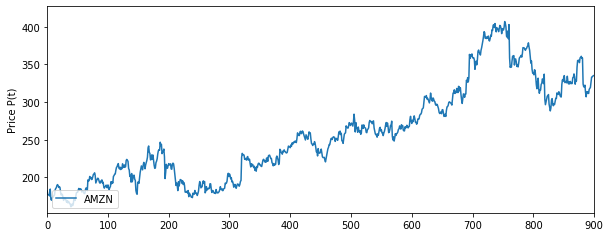

date
2011-01-19     -0.000699
2011-01-20      3.430310
2011-01-21      7.885089
2011-01-24      8.455082
2011-01-25      8.604629
                 ...    
2014-08-12     99.843286
2014-08-13    106.671664
2014-08-14    106.984576
2014-08-15    106.564576
2014-08-18    105.664575
Name: close, Length: 900, dtype: float64
date
2011-01-19    -0.000970
2011-01-20     4.760906
2011-01-21     6.976045
2011-01-24     7.525967
2011-01-25     7.669560
                ...    
2014-08-12    57.607744
2014-08-13    50.791603
2014-08-14    44.040169
2014-08-15    43.620169
2014-08-18    42.720167
Name: close, Length: 900, dtype: float64
date
2011-01-19     -0.000999
2011-01-20      4.903294
2011-01-21      2.842925
2011-01-24      3.409080
2011-01-25      3.263911
                 ...    
2014-08-12    212.521773
2014-08-13    218.286055
2014-08-14    211.356141
2014-08-15    210.936141
2014-08-18    210.036141
Name: close, Length: 900, dtype: float64


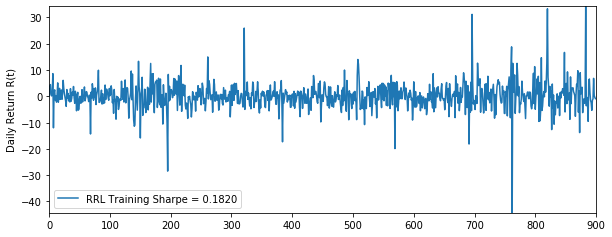

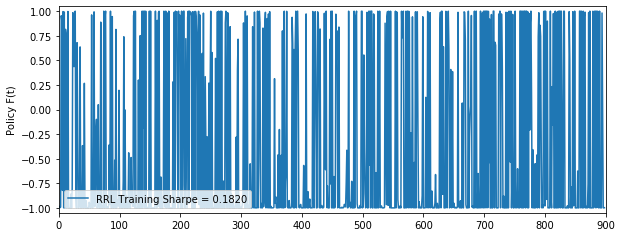

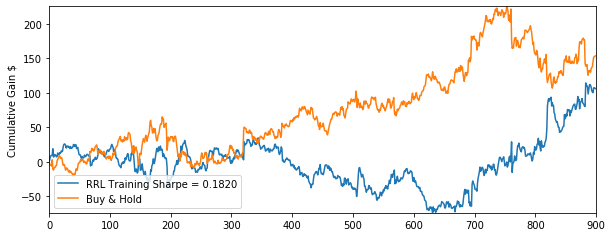

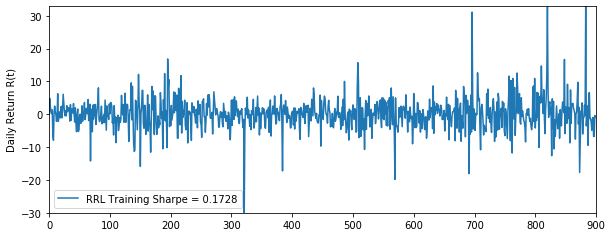

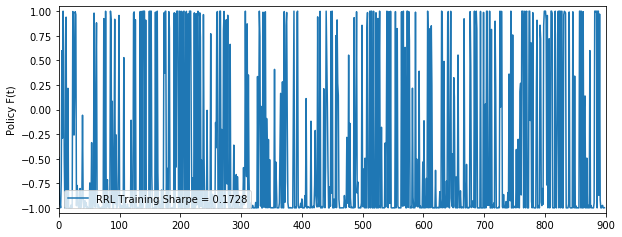

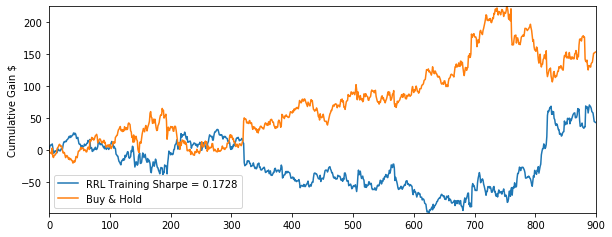

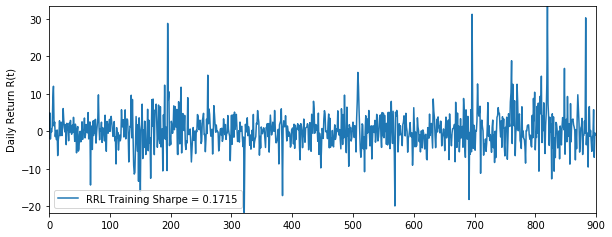

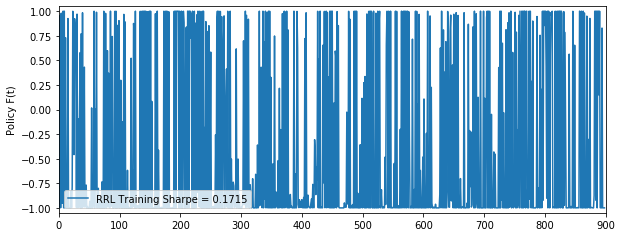

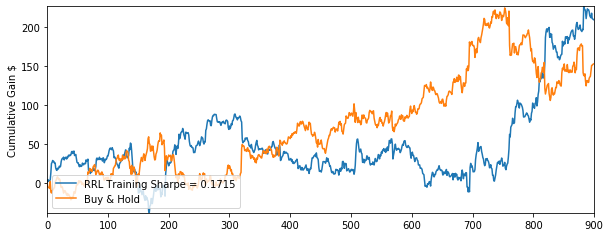

In [0]:
import matplotlib.pyplot as plt
price_diff = (df_test['close'] - df_test['close'].shift(1)).dropna()
X = price_diff[:] # truncate input data
X_norm , _ , _ = featureNormalize(X)

M = 10
T = 900 # size of input in testing set
mu = 1
delta = 0.001

# f, axarr = plt.subplots(4, sharex=True)

# Plot price in the testing set
plt.figure(0, figsize=[9.8, 3.8])
plt.plot(range(len(df_test['close'][M+2:M+T+2])), df_test['close'][M+2:M+T+2], label = "AMZN");
plt.axis([0, T, min(df_test['close'][M+2:M+T+2])*0.95, max(df_test['close'][M+2:M+T+2])*1.05]);
plt.ylabel('Price P(t)');
plt.legend(loc='lower left')
plt.show()

for i in [0, 1, 2]:
  
  Ft = updateFt(top_theta[i], X_norm, T)
  R_t = mu * (Ft[0:T] * X[M:M+T] - delta * abs(Ft[1:]-Ft[0:T]))
  
  # Plot Daily Returns as defined
  plt.figure(1 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(R_t)), R_t[:], label = "RRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.axis([0, len(R_t), min(R_t), max(R_t)]);
  plt.ylabel('Daily Return R(t)');
  plt.legend(loc='lower left')
  
  
  Ret = R_t.copy()
  for j in range(1,len(Ret)):
    Ret[j] = Ret[j-1] + Ret[j]

  print(Ret)

  # Plot Policy
  plt.figure(4 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(Ft[2:])), Ft[2:], label = "RRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.axis([0, len(Ft)-1, -1.05, 1.05]);
  plt.ylabel('Policy F(t)');
  plt.legend(loc='lower left')
  
  # Plot Cumulative Gain
  plt.figure(7 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(Ret)), Ret[:], label = "RRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.plot(range(len(df_test['close'][M+2:M+T+2])), df_test['close'][M+2:M+T+2] - df_test['close'][M+2], label = "Buy & Hold");
  plt.axis([0, len(Ret), min(min(Ret), min(df_test['close'][M+2:M+T+2] - df_test['close'][M+2])), max(max(Ret), max(df_test['close'][M+2:M+T+2] - df_test['close'][M+2]))]);
  plt.ylabel('Cumulative Gain $');
  plt.legend(loc='lower left')

plt.show()

## 4.2 Rule-based RRL (RbRRL)

In [18]:
'''
price_diff = (df_train['close'] - df_train['close'].shift(1)).dropna()
X = price_diff[:] # truncate input data
X_norm , _ , _ = featureNormalize(X)

# Check available technical indicators. They are readily for future use.
regex = '^(sma|ema|wma|macd)' 
df_train.filter(regex=regex).head(3)
'''

"\nprice_diff = (df_train['close'] - df_train['close'].shift(1)).dropna()\nX = price_diff[:] # truncate input data\nX_norm , _ , _ = featureNormalize(X)\n\n# Check available technical indicators. They are readily for future use.\nregex = '^(sma|ema|wma|macd)' \ndf_train.filter(regex=regex).head(3)\n"

In [19]:
# Future Work: expand technical indicator universe
'''
signal_df = df_train.filter(regex=regex).copy()
signal_df['SMA_6_50'] = (signal_df['sma_6'] - signal_df['sma_50']).apply(np.sign)
signal_df['EMA_5_20'] = (signal_df['ema_5'] - signal_df['ema_20']).apply(np.sign)
signal_df['WMA_4_14'] = (signal_df['wma_4'] - signal_df['wma_14']).apply(np.sign)

#visualization
plt.figure(650, figsize=[9.8, 3.8])
plt.plot(range(len(signal_df.index)), signal_df['SMA_6_50'], label='SMA_6_50')
plt.ylabel('Trading Signal')
plt.show()

plt.figure(520, figsize=[9.8, 3.8])
plt.plot(range(len(signal_df.index)), signal_df['EMA_5_20'], label='EMA_5_20')
plt.ylabel('Trading Signal')
plt.show()

plt.figure(414, figsize=[9.8, 3.8])
plt.plot(range(len(signal_df.index)), signal_df['WMA_4_14'], label='WMA_4_14')
plt.ylabel('Trading Signal')
plt.show()
'''

"\nsignal_df = df_train.filter(regex=regex).copy()\nsignal_df['SMA_6_50'] = (signal_df['sma_6'] - signal_df['sma_50']).apply(np.sign)\nsignal_df['EMA_5_20'] = (signal_df['ema_5'] - signal_df['ema_20']).apply(np.sign)\nsignal_df['WMA_4_14'] = (signal_df['wma_4'] - signal_df['wma_14']).apply(np.sign)\n\n#visualization\nplt.figure(650, figsize=[9.8, 3.8])\nplt.plot(range(len(signal_df.index)), signal_df['SMA_6_50'], label='SMA_6_50')\nplt.ylabel('Trading Signal')\nplt.show()\n\nplt.figure(520, figsize=[9.8, 3.8])\nplt.plot(range(len(signal_df.index)), signal_df['EMA_5_20'], label='EMA_5_20')\nplt.ylabel('Trading Signal')\nplt.show()\n\nplt.figure(414, figsize=[9.8, 3.8])\nplt.plot(range(len(signal_df.index)), signal_df['WMA_4_14'], label='WMA_4_14')\nplt.ylabel('Trading Signal')\nplt.show()\n"

### Component rule universe

**Simple Moving Average**: the mean of stock prices over a moving window of n days as follows:
$$\bar{p} = \frac{1}{n}\sum_{i=t-n+1}^{t} p_{i}$$
where $t$ is the current trading day and $p_{i}$ is the close stock price on day $i$. It is recalculated and updated each trading day. 

<br>Parameter values to be used in this study:

$m$ (number of days in a long-period moving average) = 5, 10, 15,
20, 25, 30, 40, 50, 75, 100, 125, 150, 200, 250 (14 values);

$n$ (number of days in a short-period moving average) = 1, 2, 5,
10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 200 (15 values).

Because $n$ should be less than $m$, the total number of MA rules generated is 119.

**Trading range break-out (TRB)**: It calculates the highest close price $H$ and the lowest close
price $L$ over a fixed $n$ days interval as follows:
$$H = \max(p_{t-1},p_{t-2},\ldots,p_{t-n})$$
$$L = \min(p_{t-1},p_{t-2},\ldots,p_{t-n})$$
The highest and lowest price form a running channel (trading
range) for each day’s stock price and the trading signals are invoked
by the stock price’s breakout from the channel. Suppose the close price of trading day $t$ is $p_{t}$, a buy signal is generated when $p_{t} > H$ and
a sell signal is generated when $p_{t} < L$. Below are the parameter values:

$n$ (number of days for a trading range) = 5, 10, 15, 20, 25, 30, 35,
40, 45, 50, 60, 70, 75, 80, 90, 100, 125, 150, 175, 200, 250 (21
values).<br>
Because there is only one parameter, the total number of TRB
rules generated is 21.

In [0]:
#for component universe selection
import pandas as pd
import numpy as np

#for visualization
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
#%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters


#when calculating the M days SMA, the first M−1 are not valid, as M prices are required for the first moving average data point
#Input: (single stock price series, short window, long window, start_date = '2015-01-01', end_date = '2016-12-31')
def SMA(data, short, long_): #, start_date, end_date
    # Calculating the short-window simple moving average
    short_rolling = data.rolling(window=short).mean()
    #Calculating the long-window simple moving average
    long_rolling = data.rolling(window=long_).mean()
    # Taking the difference between the short-SMA and the long-SMA timeseries
    trading_signals_raw = short_rolling - long_rolling
    trading_signals = trading_signals_raw.apply(np.sign)
    # Lagging our trading signals by one day.
    trading_signals_final = pd.DataFrame(index=trading_signals.shift(1).index)
    trading_signals_final['SMA_'+str(short)+'_'+str(long_)] = trading_signals.shift(1)
    '''
    #visualization
    sns.set(style='darkgrid', context='talk', palette='Dark2')
    # my_year_month_fmt = mdates.DateFormatter('%m/%y')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9.8,7.6))
    
    ax1.plot(range(len(data[:].index)), data, label='Price')
    ax1.plot(range(len(long_rolling[:].index)), long_rolling, label = str(long_)+'-day SMA')
    ax1.plot(range(len(short_rolling[:].index)), short_rolling, label = str(short)+'-day SMA')
    ax1.legend(loc='best')
    ax1.set_ylabel('Price in $')
    # ax1.xaxis.set_major_formatter(my_year_month_fmt)
    ax2.plot(range(len(trading_signals_final[:].index)), trading_signals_final, label='Trading signal')
    ax2.set_ylabel('Trading signal')
    # ax2.xaxis.set_major_formatter(my_year_month_fmt)
    '''
    return trading_signals_final
    
    
# #EMA: to reduce the lag induced by SMA, to put more weights on more recent observations
# #Input: (dataframe, time span) 
# def EMA(data, T): #, start_date, end_date
#     # Using Pandas to calculate a T-day span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
#     ema_T = data[['Close']].ewm(span=T, adjust=False).mean()
#     # Taking the difference between the prices and the EMA timeseries
#     trading_signals_raw = data[['Close']] - ema_T
#     trading_signals = trading_signals_raw.apply(np.sign)
#     # Lagging our trading signals by one day.
#     trading_signals_final = trading_signals.shift(1)
#     trading_signals_final.columns = ['EMA_'+str(T)]
    
#     return trading_signals_final

#Input: (single stock price series, time span) 
def TRB(data, T): #, start_date, end_date
    #rolling_max/min includes the current one          
    max_rolling = data.rolling(window=T).max().shift(1)
    min_rolling = data.rolling(window=T).min().shift(1)
    #sliced column for boolean comparison
    buysig = data > max_rolling
    sellsig = data < min_rolling
    trading_signals = (buysig.astype(int) - sellsig.astype(int)).to_frame()
    # Lagging our trading signals by one day.
    trading_signals_final = pd.DataFrame(index=trading_signals.shift(1).index)
    trading_signals_final['TRB_'+str(T)] = trading_signals.shift(1)
    '''
    #visualization
    sns.set(style='darkgrid', context='talk', palette='Dark2')
    # my_year_month_fmt = mdates.DateFormatter('%m/%y')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9.8,7.6))
    
    ax1.plot(range(len(data[:].index)), data, label='Price')
    ax1.plot(range(len(max_rolling[:].index)), max_rolling, label = 'Moving Max')
    ax1.plot(range(len(min_rolling[:].index)), min_rolling, label = 'Moving Min')
    ax1.legend(loc='best')
    ax1.set_ylabel('Price in $')
    # ax1.xaxis.set_major_formatter(my_year_month_fmt)
    ax2.plot(range(len(trading_signals_final[:].index)), trading_signals_final, label='Trading signal')
    ax2.set_ylabel('Trading signal')
    # ax2.xaxis.set_major_formatter(my_year_month_fmt)
    '''
    return trading_signals_final

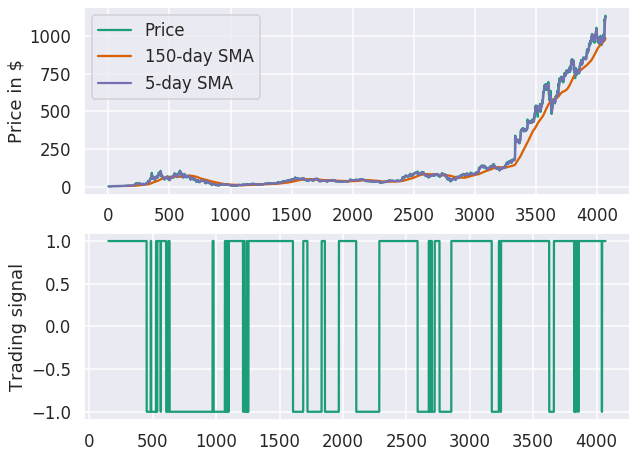

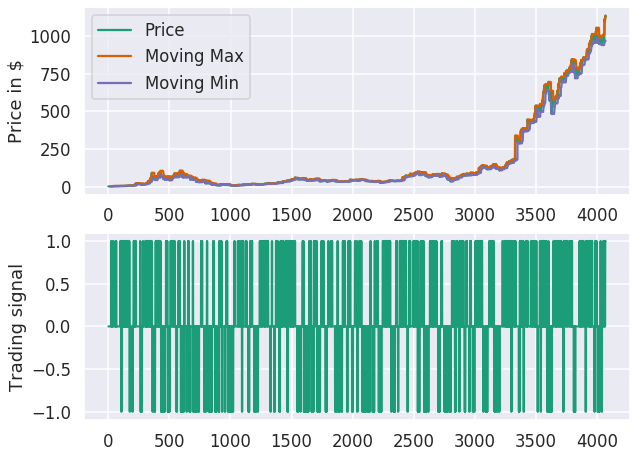

In [20]:
# Visualize Technical rules
SMA_5_150_df = SMA(df_train['close'], 5, 150)
TRB_20_df = TRB(df_train['close'], 20)

In [0]:
import numpy as np

#Input: single stock closing prices
def RuleUniverse(data):
    signal_df = data.copy()
    #SMA parameter space
    SP = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 200] #15 values
    LP = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 200, 250] #14 values

    #TRB parameter space
    T = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 75, 80, 90, 100, 125, 150, 175, 200, 250] #21 values
    
    count = 0
    for j in range(len(SP)):
        for i in range(len(LP)):
            if SP[j] < LP[i]:
                df_temp = SMA(data, SP[j], LP[i])
                signal_df = pd.concat([signal_df, df_temp], axis=1)
                count = count + 1
                
    for k in range(len(T)):
        df_temp = TRB(data, T[k])
        signal_df = pd.concat([signal_df, df_temp], axis=1)
        count = count + 1
    #print (str(count) + ' Rules!')    
    return signal_df.dropna()

In [23]:
# Note that we dropped any NaN of signals in the dataframe
ruleUniverse = RuleUniverse(df_train['close'])
ruleUniverse #[ruleUniverse.isna().any(axis=1)]

,close,SMA_1_5,SMA_1_10,SMA_1_15,SMA_1_20,SMA_1_25,SMA_1_30,SMA_1_40,SMA_1_50,SMA_1_75,SMA_1_100,SMA_1_125,SMA_1_150,SMA_1_200,SMA_1_250,SMA_2_5,SMA_2_10,SMA_2_15,SMA_2_20,SMA_2_25,SMA_2_30,SMA_2_40,SMA_2_50,SMA_2_75,SMA_2_100,SMA_2_125,SMA_2_150,SMA_2_200,SMA_2_250,SMA_5_10,SMA_5_15,SMA_5_20,SMA_5_25,SMA_5_30,SMA_5_40,SMA_5_50,SMA_5_75,SMA_5_100,SMA_5_125,SMA_5_150,...,SMA_50_125,SMA_50_150,SMA_50_200,SMA_50_250,SMA_75_100,SMA_75_125,SMA_75_150,SMA_75_200,SMA_75_250,SMA_100_125,SMA_100_150,SMA_100_200,SMA_100_250,SMA_125_150,SMA_125_200,SMA_125_250,SMA_150_200,SMA_150_250,SMA_200_250,TRB_5,TRB_10,TRB_15,TRB_20,TRB_25,TRB_30,TRB_35,TRB_40,TRB_45,TRB_50,TRB_60,TRB_70,TRB_75,TRB_80,TRB_90,TRB_100,TRB_125,TRB_150,TRB_175,TRB_200,TRB_250
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-08-10,20.27,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-08-11,20.67,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-08-12,21.73,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-08-13,21.25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-08-14,20.46,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-03,1111.60,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-06,1120.66,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-11-07,1123.17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Individual Rule Returns

A more ideal model for the potential return of each rule should be the following. This is however not implemented in this code to ensure consistency with RRL assumptions. 

On day $t$, a component rule $i$ has return $r_{t,i}$ where 

$$
1 + r_{t,i} = [1 + (1 - |S_{t-1,i}|)R^{f}_{t} + S_{t-1,i}R_{t}]\times[1 - \delta|S_{t,i} - S_{t-1,i}|].
$$

Consider a trading day $t$, each component rule $i$ indicates a signal $S_{t,i} \in \{long, neutral, short\} = \{1, 0, -1\}.$ With $P_{t}$ being the asset price at time $t$, $R_{t} = (P_{t}/P_{t-1}) - 1$ is the asset price return. The risk-free rate of interest $R^{f}_{t}$ is calculated similarly. $\delta$ denotes the transaction cost rate.

In [0]:
def RulePerformance(signal_df, T, M, mu = 1, delta = 0.001):
  # Input: signal_df from RuleUniverse
  #        T = the number of time series inputs to the trader
  #        M = the look-back window size such that the ultimate sharpe is calculated using the defined return over time starting from day M to day M+T.
  #        mu = maximum possible number of shares per transaction; 
  #        delta = cost per transaction;
  # Output: Ret = a series of returns as defined over time [M, M+T]
  price_diff = (signal_df['close'] - signal_df['close'].shift(1)).dropna()
  X = price_diff[:] # truncate input data
  X_norm , _ , _ = featureNormalize(X)
  Ft = signal_df.iloc[0:, 1:].copy()
  # first term: element-wise multiplication; second term: constant broadcasting
  # Note that we start with the M-th row for policy here
  Ret = mu * (Ft.iloc[M-1:M-1+T,:].mul(X_norm[M:M+T], axis=0) - delta * (Ft.iloc[M:M+T,:]-Ft.iloc[M-1:M-1+T,:]).abs())
  return Ret.dropna()

In [0]:
# rulePerformance = RulePerformance(ruleUniverse, 1000, 10, mu = 1, delta = 0.001)
# rulePerformance

### Signal Weighting Approximation inspired by RRL


We assign each component rule $i$ a weight $\omega_{t,i}$ at time $t$, to later generate a system signal through linear combination of individual signals.
$$\omega_{t,i} = softmax[\langle\mathbf{v},\mathbf{x}_{t,i}\rangle + b + u\omega_{t-1,i}]$$
In the bracket, $\langle\cdot,\cdot\rangle$ is the inner product, $\mathbf{x}_{t,i}$ defines the feature vector of the current market condition at time $t$ for rule $i$, and $(\mathbf{v},b)$ are the feature regression coefficients. Similar to RRL, we adopt the recent $m$ rule returns as the feature vector
$$
\mathbf{x}_{t,i} = [r_{t-m,i},\ldots,r_{t-1,i}] \in \mathbb{R} ^{m}$$
In addition to the features, another term $u\omega_{t-1, i}$, where $\omega_{t-1,i}$ stands for the rule weighting at time $t-1$, is also added
into the regression to take the latest weighting into
consideration. This term is used to discourage the agent to
frequently change the trading positions and, hence, to avoid
heavy transaction costs.

The optimization
of the contextualized RRL here aims to learn such a family of parameter set $\Theta = \{\mathbf{v}, b, u\}$ that can maximize the global reward function to be defined later.

In [0]:
from scipy.special import softmax

#Input: (RuleReturn from RulePerformance WITHOUT 'close' or other columns, Review span Theta, Parameter list theta of length = M+2)
def RuleWeighting(RuleReturn, M, theta):
    NumofRules = len(RuleReturn.columns)
    #Initialize all weights at each time to be equal weights (e.g. 1/140), to be updated later
    Weights = pd.DataFrame(1/NumofRules, index=RuleReturn.index, columns=RuleReturn.columns)
    #Create an EtaTable (weighting before softmax) and assign entries row by row using previous values
    EtaTable = pd.DataFrame(np.nan, index=RuleReturn.index, columns=RuleReturn.columns)

    for i in range(1+M, len(Weights.index)):
        prev_weight = Weights.iloc[i-1,:].copy()
        Review_ret = RuleReturn.iloc[(i-M-1):i-1,:].T.copy() # transpose for dot product with theta
        dot_product = (Review_ret.dot(theta[0:M])).T
        EtaTable.iloc[i,:] = dot_product + theta[M] + theta[M+1] * prev_weight
        Weights.iloc[i,:] = softmax(EtaTable.iloc[i,:])
       
    return Weights.iloc[M:,:]

In [0]:
# temp = RuleWeighting(rulePerformance, 2, np.array([1,2,1,2]))
# print(temp)
# regex = '^(TRB)'
# print(len(temp.filter(regex=regex).columns))

### System signal generation

The Performance Reward-based Strategy generates the system signal $S_{t}$ simply by $S_{t} = \sum \omega_{t,i}S_{t,i}$. Nevertheless, this may result in the case that many under-performing rules dominate the few truly useful rules due to adding many yet small weights. To address the possible noise, we only select the best rule (that is assigned the highest weighting) each time within each rule class and combine them across different classes. For instance, in the predefined set of rule classes $C = $ \{MA, TRB\}, we have
$$
  S_{t} =
  \begin{cases}
  1 & \text{if $\alpha \sum_{k \in C} \omega^{k}_{t}S^{k}_{t} + (1-\alpha) S_{t-1} > l$} \\
 -1 & \text{if $\alpha \sum_{k \in C} \omega^{k}_{t}S^{k}_{t} + (1-\alpha) S_{t-1} < s$} \\
  0 & \text{otherwise}
  \end{cases}
$$
where $\omega^{k}_{t}$ and $S^{k}_{t}$ represents the re-normalized weight and signal of the best rule within class $k$ at time $t$, respectively. A new decay parameter $\alpha \in [0, 1]$ is introduced to incorporate the previous trading decision for cost-reducing purpose. Eventually, two threshold parameters $l \in [0, 1)$ and $s \in (-1, 0]$ are utilized to discretize the signal.

In [0]:
# This differentiates our model from RRL, which used a simple activation tanh() function

#Input: (Individual Signal from RuleUniverse, Dynamic Weights from RuleWeighting, Decay factor alpha, Buy threshold, Sell threshold, Review M)
#Output: a trading signal series
def SystemSignal(ruleUniverse, DWeights, alpha, Buy, Sell, M):
    
    NumofRules = len(ruleUniverse.columns)-1
    #Ignore the first non-signal column
    temp = ruleUniverse.iloc[:, 1:].copy()
    # Match the dates
    ISignals = temp[temp.index.isin(DWeights.index)]
    s = pd.DataFrame(0, columns = ['combined'], index=DWeights.index) #Initialize to zero

    NumofSMA = len(temp.filter(regex='^(SMA)').columns)
    NumofTRB = len(temp.filter(regex='^(TRB)').columns)

    for i in range(1, len(DWeights.index)):
      max_SMA_wei = DWeights.iloc[i,0:NumofSMA].max()
      max_TRB_wei = DWeights.iloc[i,NumofSMA:NumofSMA+NumofTRB].max()
      max_SMA_sig = ISignals.iloc[i][DWeights.iloc[i,0:NumofSMA].idxmax()]
      max_TRB_sig = ISignals.iloc[i][DWeights.iloc[i,NumofSMA:NumofSMA+NumofTRB].idxmax()]
  
      # Re-normalize the two best weights by softmax
      [max_SMA_wei, max_TRB_wei] = softmax([max_SMA_wei, max_TRB_wei])

      #Continuous case: s.iloc[i] = alpha * dot_product + (1-alpha) * s.iloc[i-1]
      dot_product = max_SMA_wei * max_SMA_sig + max_TRB_wei * max_TRB_sig
      cont = (alpha * dot_product + (1-alpha) * s.iloc[i-1]).item()
      # print(cont)
      if (cont > Buy):
          s.iloc[i] = 1
      elif (cont < Sell):
          s.iloc[i] = -1
      else:
          s.iloc[i] = 0
        
    return s  

In [0]:
# SystemSignal(ruleUniverse, temp, 0.9, 0.5, -0.5, 10)

All parameters to be learned:
$\{\Theta, \alpha, l, s\}$,
<br>where $\Theta = \{\mathbf{v}, b, u\}$

In [0]:
def reward_RbRRL(param, close, T, M, mu = 1, delta = 0.001):
  # Input: param = [theta, [alpha, l, s]], where theta = [v1, v2, ..., vm, b, u]
  #        close = df_train['close'];
  #        T = the number of time series inputs to the trader
  #        M = the look-back window size such that the ultimate sharpe is calculated using the defined return over time starting from day M to day M+T.
  #        mu = maximum possible number of shares per transaction; 
  #        delta = cost per transaction;
  # Output: Ret = a series of returns as defined over time [M, M+T]

  theta = param[0]
  alpha = param[1][0]
  Buy = param[1][1]
  Sell = param[1][2]

  ruleUniverse = RuleUniverse(close)
  RuleReturn = RulePerformance(ruleUniverse, T, M, mu, delta)
  DWeights = RuleWeighting(RuleReturn, M, theta)
  Ft = SystemSignal(ruleUniverse, DWeights, alpha, Buy, Sell, M)
  # first term: element-wise multiplication; second term: constant broadcasting

  # Match the dates
  matched_series = close[close.index.isin(Ft.index)]
  diff = (matched_series - matched_series.shift(1)).dropna() # thus first row corresponds to second row of Ft
  X_norm , _ , _ = featureNormalize(diff)

  shifted_Ft = Ft.shift(1).dropna() # Dataframe, while X_norm is Series

  Ret_len = min(len(shifted_Ft), T)

  Ret = mu * ((shifted_Ft.iloc[:,0].multiply(X_norm)) - delta * (abs(Ft-shifted_Ft).dropna()).iloc[:,0])
  #print(Ret)
  sharpe = sharpeRatio(Ret)
  #print(sharpe)
  return sharpe

Training

In [0]:
np.random.seed(2020)

def RbRRLTrain_sampling(close, M = 10, T = 1000, num_epochs = 10000):
  # Input: close = df_train['close'];
  #        M = look-back window length
  #        T = the number of time series inputs to the trader
  # Output:
  obj_max, param_max = [], []
  temp_reward_max = 0
  theta_temp = np.zeros((M+2,))
  other_temp = [0.5, 0.55, -0.55] # alpha, buy, short initialized 
  temp_param_max = [theta_temp, other_temp]

  for i in range(num_epochs):

    theta_temp = np.clip(temp_param_max[0] + np.random.randn(M+2), -3., 3.) # Control the parameter to stay in the search space 
    other_temp = np.clip(temp_param_max[1] + np.random.normal(0, 0.25, 3), [0.001, 0.1, -0.999], [0.999, 0.999, -0.1])
    temp_param = [theta_temp, other_temp]

    temp_reward = reward_RbRRL(temp_param, close, T, M, mu = 1, delta = 0.001)
    if temp_reward > temp_reward_max:
      temp_reward_max = temp_reward
      temp_param_max = temp_param
    if i % 100 == 0:
      print("Cumulating up to Epoch " + str(i) + ": Max Reward = " + str(temp_reward_max) + " with param = " + str(temp_param_max))
      obj_max.append(temp_reward_max)
      param_max.append(temp_param_max)

  #print(theta)
  return obj_max, param_max

In [0]:
# obj_max, param_max = RbRRLTrain_sampling(df_train['close'], M = 10, T = 1000, num_epochs = 10000)

In [0]:
# Store the top three reward with its sampled parameter
# distinct_obj_max = list(set(obj_max))
# top_obj = sorted(distinct_obj_max, reverse=True)[:3]
# top_param = [param_max[obj_max.index(top_obj[i])] for i in range(3)]
# print(top_obj, top_param)

# Trained Parameters
top_obj = [0.06090273071061985, 0.055668844144956, 0.05509354921018361]
top_param = [
        [[ 1.11373285, -0.00662805, -3.        , -3.        ,  0.57683471,
       -1.18212809,  3.        ,  3.        ,  3.        ,  1.85645148,
        1.0785497 , -2.29664082], [ 0.87910868,  0.27290328, -0.54302149]],
       [[ 2.39040745, -0.03218784, -2.71391909, -3.        ,  0.67526959,
       -1.56799018,  2.63553355,  3.        ,  2.76804852,  1.39944866,
        0.54073344, -2.21554016], [ 0.87070978,  0.36341988, -0.52178869]],
        [[ 0.54018934,  0.61933831, -3.        , -3.        ,  1.10040936,
       -1.01648918,  1.88859757,  3.        ,  3.        ,  1.80280432,
        1.28657938, -2.02740222], [ 0.78255577,  0.49862335, -0.52123506]]]


Testing

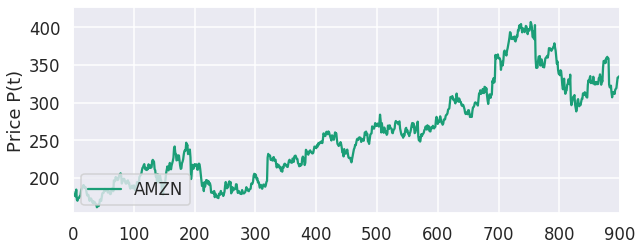

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: `item` has been deprecated and will be removed in a future version


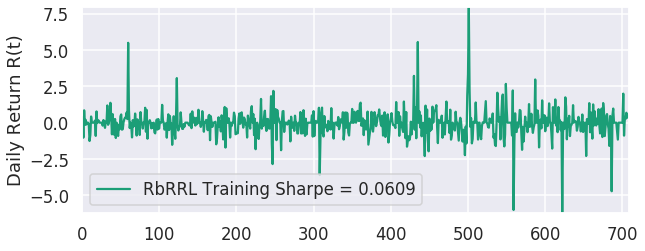

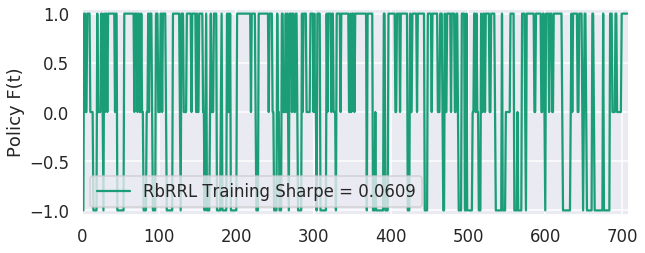

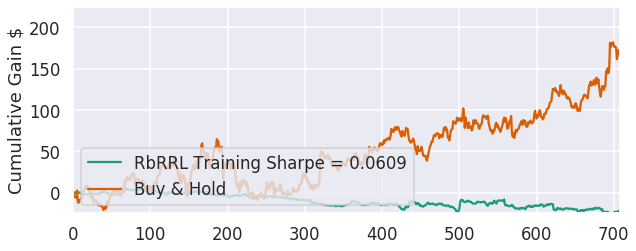

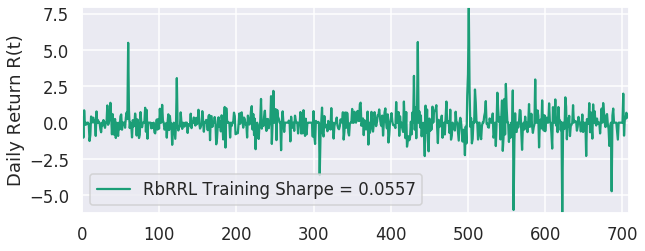

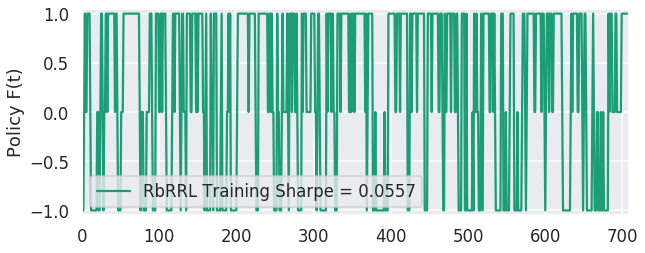

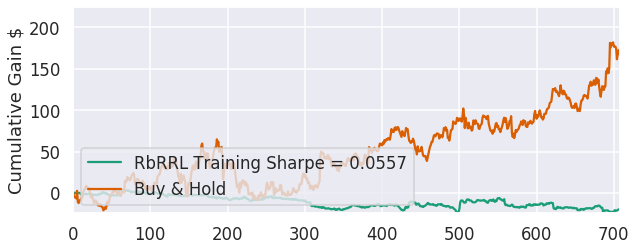

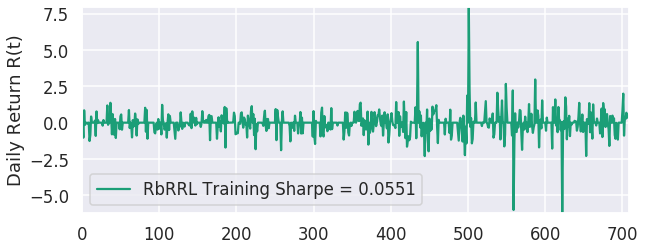

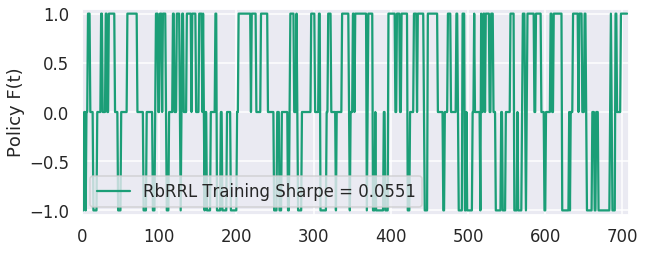

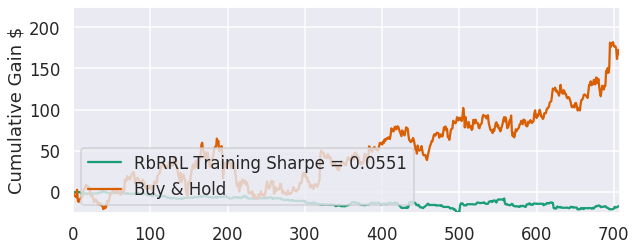

In [33]:
import matplotlib.pyplot as plt

M = 10
T = 900 # size of input in testing set
mu = 1
delta = 0.001

# f, axarr = plt.subplots(4, sharex=True)

# Plot price in the testing set
plt.figure(0, figsize=[9.8, 3.8])
plt.plot(range(len(df_test['close'][M+2:M+T+2])), df_test['close'][M+2:M+T+2], label = "AMZN");
plt.axis([0, T, min(df_test['close'][M+2:M+T+2])*0.95, max(df_test['close'][M+2:M+T+2])*1.05]);
plt.ylabel('Price P(t)');
plt.legend(loc='lower left')
plt.show()

close = df_test['close']

for i in [0, 1, 2]:
  
  param = top_param[i]

  theta = param[0]
  alpha = param[1][0]
  Buy = param[1][1]
  Sell = param[1][2]

  ruleUniverse = RuleUniverse(close)
  RuleReturn = RulePerformance(ruleUniverse, T, M, mu, delta)
  DWeights = RuleWeighting(RuleReturn, M, theta)
  Ft = SystemSignal(ruleUniverse, DWeights, alpha, Buy, Sell, M)

  # Match the dates
  matched_series = close[close.index.isin(Ft.index)]
  diff = (matched_series - matched_series.shift(1)).dropna() # thus first row corresponds to second row of Ft
  X_norm , _ , _ = featureNormalize(diff)
  shifted_Ft = Ft.shift(1).dropna() # Dataframe, while X_norm is Series
  Ret_len = min(len(shifted_Ft), T)
  Ret = mu * ((shifted_Ft.iloc[:,0].multiply(X_norm)) - delta * (abs(Ft-shifted_Ft).dropna()).iloc[:,0])
  
  # Plot Daily Returns as defined
  plt.figure(1 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(Ret)), Ret[:], label = "RbRRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.axis([0, len(Ret), min(Ret), max(Ret)]);
  plt.ylabel('Daily Return R(t)');
  plt.legend(loc='lower left')
  

  cRet = Ret.copy()
  for j in range(1,len(cRet)):
    cRet[j] = cRet[j-1] + cRet[j]

  # print(cRet)

  # Plot Policy
  plt.figure(4 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(Ft[2:])), Ft[2:], label = "RbRRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.axis([0, len(Ft)-1, -1.05, 1.05]);
  plt.ylabel('Policy F(t)');
  plt.legend(loc='lower left')
  
  # Plot Cumulative Gain
  plt.figure(7 + i, figsize=[9.8, 3.8])
  plt.plot(range(len(cRet)), cRet[:], label = "RbRRL Training Sharpe = " + format(top_obj[i], '.4f'));
  plt.plot(range(len(df_test['close'][M+2:M+T+2])), df_test['close'][M+2:M+T+2] - df_test['close'][M+2], label = "Buy & Hold");
  plt.axis([0, len(cRet), min(min(cRet), min(df_test['close'][M+2:M+T+2] - df_test['close'][M+2])), max(max(cRet), max(df_test['close'][M+2:M+T+2] - df_test['close'][M+2]))]);
  plt.ylabel('Cumulative Gain $');
  plt.legend(loc='lower left')

plt.show()

# References:

*   Historical daily prices (adjusted for dividends and splits) and volumes of all U.S. stocks and ETFs (up to 11/10/2017) by Boris Marjanovic: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
*   Data consolidation with technical indicators by Alex Wilf: https://github.com/abwilf/daytrader

